In [2]:
import collections
import inspect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import graphiclog
from graphiclog import utils, io

In [3]:
graphiclog.__file__, dir(graphiclog)

('/Users/zanejobe/opt/anaconda3/lib/python3.7/site-packages/graphiclog/__init__.py',
 ['Bed',
  'BedSequence',
  '__builtins__',
  '__cached__',
  '__doc__',
  '__file__',
  '__loader__',
  '__name__',
  '__package__',
  '__path__',
  '__spec__',
  'bed',
  'defaults',
  'io',
  'sequence',
  'utils',
  'wentworth'])

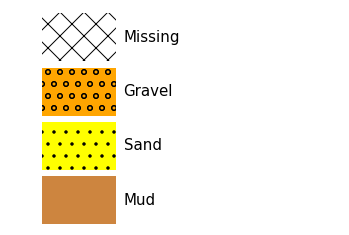

In [4]:
graphiclog.defaults.litholegend.plot()

## Import data and do some checks

In [5]:
transforms = {c : graphiclog.utils.string2array_pandas for c in ['depth_m', 'grain_size_mm', 'grain_size_psi']}

beds = pd.read_csv('../data/AllBedsWithProfiles_CLEAN.csv', converters=transforms)
beds.head()

,name,count,collection,eod,eodnum,tops,th,bases,gs_tops_mm,gs_tops_psi,...,max_gs_mm,max_gs_psi,ng,ar,depth_m,rel_depth_m,grain_size_mm,grain_size_psi,missing_tops,missing_sample
0,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,22.81684,0.31082,22.50602,0.115051,-3.1197,...,0.117046,-3.0948,0.520514,0.021978,"[22.8168, 22.703, 22.5337, 22.506]",[0. 0.1138 0.2831 0.3108],"[0.1151, 0.1157, 0.117, 0.117]","[-3.119, -3.1115, -3.0954, -3.0954]",0.0,0.0
1,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,22.50602,0.60931,21.89671,0.001000,-9.9658,...,0.001000,-9.9658,0.520514,0.021978,"[22.506, 21.8967]",[0. 0.6093],"[0.001, 0.001]","[-9.9658, -9.9658]",0.0,0.0
2,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,21.89671,0.10463,21.79208,0.125380,-2.9956,...,0.125380,-2.9956,0.520514,0.021978,"[21.8967, 21.7921]",[0. 0.1046],"[0.1254, 0.1254]","[-2.9954, -2.9954]",0.0,0.0
3,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,21.79208,0.11694,21.67514,0.001000,-9.9658,...,0.001000,-9.9658,0.520514,0.021978,"[21.7921, 21.6751]",[0. 0.117],"[0.001, 0.001]","[-9.9658, -9.9658]",0.0,0.0
4,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,21.67514,0.13232,21.54282,0.134306,-2.8964,...,0.160420,-2.6401,0.520514,0.021978,"[21.6751, 21.6351, 21.5674, 21.5428]",[0. 0.04 0.1077 0.1323],"[0.1343, 0.1447, 0.1604, 0.1604]","[-2.8965, -2.7889, -2.6403, -2.6403]",0.0,0.0


In [6]:
beds[beds.depth_m.apply(utils.safelen) != beds.grain_size_mm.apply(utils.safelen)]

,name,count,collection,eod,eodnum,tops,th,bases,gs_tops_mm,gs_tops_psi,...,max_gs_mm,max_gs_psi,ng,ar,depth_m,rel_depth_m,grain_size_mm,grain_size_psi,missing_tops,missing_sample


In [7]:
# check for zero thickness
beds[beds.gs_tops_mm.isnull()].th.sum(), beds[beds.snd_shl.isnull()].th.sum()

(0.0, 0.0)

In [8]:
# check for other wierdness
weird = {problem : [] for problem in ['has_null', 'th_mismatch', 'samples_mismatch']}

for name, seq in beds.groupby('count'):
    
    if seq.isnull().any().any():
        weird['has_null'].append(name)
    
    _, elev_good = io.check_thicknesses(seq, 'tops', 'th', 'elevation')
    _, depth_good = io.check_thicknesses(seq, 'tops', 'th', 'depth')
    if not (elev_good or depth_good):
        weird['th_mismatch'].append(name)
        
    if not io.check_samples(seq, 'depth_m', 'grain_size_mm'):
        weird['samples_mismatch'].append(name)
        
weird, {k : len(v) for k, v in weird.items()}

/Users/zanejobe/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


({'has_null': [], 'th_mismatch': [], 'samples_mismatch': []},
 {'has_null': 0, 'th_mismatch': 0, 'samples_mismatch': 0})

In [9]:
{k : len(v) for k, v in weird.items()}

{'has_null': 0, 'th_mismatch': 0, 'samples_mismatch': 0}

## Some simple stats

In [10]:
# number of sand (1) and mud (0) beds
beds.snd_shl.value_counts()

1.0    28918
0.0    27997
Name: snd_shl, dtype: int64

In [11]:
print('total mud th', beds[beds.snd_shl == 0].th.sum(),'m')
print('average mud th',beds[beds.snd_shl == 0].th.mean(),'m')

print(' ')

print('total sand th ', beds[beds.snd_shl == 1].th.sum(),'m')
print('average sand th',beds[beds.snd_shl == 1].th.mean(),'m')

total mud th 6994.021388571157 m
average mud th 0.24981324386795337 m
 
total sand th  12742.218893650996 m
average sand th 0.4406327855885969 m


In [12]:
count = {eod : 0 for eod in beds.eod.unique()}
meters = {eod : 0 for eod in beds.eod.unique()}

for _, grp in beds.groupby('count'):
    count[grp['eod'].values[0]] += 1
    meters[grp['eod'].values[0]] += grp.th.sum()
    
avgs = {k : meters[k] / count[k] for k in count.keys()}
print('average log length by environment',avgs)

average log length by environment {'basin plain': 27.076829050012044, 'fan': 33.39089495971465, 'levee': 15.039543988376764, 'slopechannel': 80.6872487607637}


## Make a simple plot

In [47]:
test_log.keys()

Index(['name', 'count', 'collection', 'eod', 'eodnum', 'tops', 'th', 'bases',
       'gs_tops_mm', 'gs_tops_psi', 'snd_shl', 'snd', 'shl', 'mean_gs_mm',
       'mean_gs_psi', 'max_gs_mm', 'max_gs_psi', 'ng', 'ar', 'depth_m',
       'rel_depth_m', 'grain_size_mm', 'grain_size_psi', 'missing_tops',
       'missing_sample'],
      dtype='object')

In [49]:
datacols = ['th', 'gs_tops_psi', 'snd_shl', 'mean_gs_psi', 'max_gs_psi']



test_log = beds[beds['name'] == 'Marnoso 1'] # this is the first marnoso log, count is the matlab output
test_seq = graphiclog.BedSequence.from_dataframe(test_log, topcol='tops', basecol='bases'
                                                , datacols=datacols)
test_seq

Striplog(91 Intervals, start=0.0, stop=22.81684)

In [50]:
test_seq[0]
#test_seq.plot(width_field=)

Interval({'data': {'th': 0.31082, 'gs_tops_psi': -3.1197, 'snd_shl': 1.0, 'mean_gs_psi': -3.1069, 'max_gs_psi': -3.0948}, 'top': Position({'middle': 22.81684, 'units': 'm'}), 'base': Position({'middle': 22.50602, 'units': 'm'}), 'description': '', 'components': []})

UnboundLocalError: local variable 'min_width' referenced before assignment

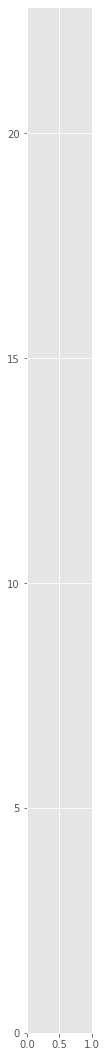

In [52]:
test_seq.plot(min_width)